In [134]:
# Imports 
import os
import xml.etree.ElementTree as et
import pandas as pd
from itertools import chain

import numpy as np
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD as LSA
import random
random.seed(13)


#visualisation stuff
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline


In [135]:
# Load data 
PATH = "../xml/"
extension = ".xml"

def load_order(PATH, extension):
    """
    Custom function for loading and sorting the xml files from the TOTA dataset.
    Returns an array of filenames sorted by the number in the file name.
    """
    files = []
    for filename in os.listdir(PATH):
        if filename == ".ipynb_checkpoints":
            continue
        files.append(filename.split(".")[0]) # remove .xml
    files.sort(key=lambda x:int(x.split("_")[1])) # sort files based on file number 

    files = [file + extension for file in files]
#     print(files)
    return files

files = load_order(PATH, extension)

In [210]:
def xml2list(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """
    parsed_xml = et.parse(file)

    root = parsed_xml.getroot()

    meta_column_names = []
    meta_column_content = []

    for item in root[0]:
        grandchild = item.findall(".//")
        if grandchild:
            grandstore = []
            #print(item.tag)
            meta_column_names.append(item.tag)
            for x in grandchild:
                grandstore.append(int(x.attrib.get('n')))
                #print(x.tag +":", x.attrib)
            meta_column_content.append(grandstore)

        else:
            #print(item.tag +":", item.text)
            meta_column_names.append(item.tag)
            meta_column_content.append(item.text)
            
    return meta_column_names, meta_column_content
    
    
def xml2list_text(file):
    """
    Custom function for parsing and outputing the data into arrays.
    Returns two array's the extracted column names and content for each column.
    """

    parsed_xml = et.parse(file)
    root = parsed_xml.getroot()
    chapters = []
    article_store = []
    
    treaty_text = ''
    
    for item in root[1]:
        chapter_name = item.attrib.get('name')
#         print("chapter: " + item.attrib.get('name'))
        chapters.append(chapter_name)
        if chapter_name == None:
            continue
        treaty_text += chapter_name + "\n"
        
        articles = item.findall("article")
        for article in articles:
#             print(article.attrib.get('name'))
            art_no = article.attrib.get('number')
            art_text =  article.text
            article_store.append(art_no)
            if art_no == None:
                continue
#             print(art_no)
            treaty_text += art_no + "\n"
            treaty_text += art_text + "\n"
        
            
    return len(chapters), len(article_store), treaty_text

In [316]:
def xml2list_chapters(file):
    parsed_xml = et.parse(PATH + file)
    root = parsed_xml.getroot()
    chapters = []
    article_store = []

    treaty_text = ''

    chapter_text_all = []
    chapter_type_all = []
    chapter_lan_all = []
    chapter_date_all = []
    
    type_agree = root[0].find('type')
    type_agree = type_agree.text
    
    lan_agree = root[0].find('language')
    lan_agree = lan_agree.text
    
    date_agree = root[0].find('date_into_force')
    if date_agree.text == None:
        date_agree = 1948
    else:
#     print(date_agree.text)
        date_agree = int(date_agree.text.split('-')[0])
    

    for item in root[1]:
        chapter_text = ''

        chapter_name = item.attrib.get('name')

        if chapter_name == None:
            continue

        chapters.append(chapter_name)

        chapter_text += chapter_name + "\n"

        articles = item.findall("article")
        for article in articles:
            art_no = article.attrib.get('number')
            art_text =  article.text
            chapter_text += art_text + "\n"

            if art_no == None:
                continue
            treaty_text += art_no + "\n"

        chapter_text_all.append(chapter_text)
        chapter_type_all.append(type_agree)
        chapter_lan_all.append(lan_agree)
        chapter_date_all.append(date_agree)

    return chapter_text_all, chapter_type_all, chapter_lan_all, chapter_date_all

In [317]:
import spacy
from spacy.tokenizer import Tokenizer
nlp = spacy.load('en')
tokenizer = Tokenizer(nlp.vocab)

In [318]:
textdf = pd.DataFrame()

treaty_text = []
treaty_types = []
treaty_language = []
treaty_date = []

for i in range(0, len(files)):
    chapters, types, language, date = xml2list_chapters(PATH + files[i])
    treaty_text.extend(chapters)
    treaty_types.extend(types)
    treaty_language.extend(language)
    treaty_date.extend(date)
    
t_txt = []
for doc in tokenizer.pipe(treaty_text, batch_size=50):
    t_txt.append(doc.text.lower())

textdf["chapter_text"] = t_txt
textdf["type"] = treaty_types
textdf["language"] = treaty_language
textdf["year"] = treaty_date

In [319]:
textdf = textdf[textdf.language == 'en']
textdf.head()

,chapter_text,type,language,year
0,preamble\npreamble japan and the kingdom of t...,Free Trade Agreement & Economic Integration Ag...,en,2007
1,general provisions\nthe objectives of this agr...,Free Trade Agreement & Economic Integration Ag...,en,2007
2,trade in goods\nfor the purposes of this chapt...,Free Trade Agreement & Economic Integration Ag...,en,2007
3,rules of origin\nfor the purposes of this chap...,Free Trade Agreement & Economic Integration Ag...,en,2007
4,customs procedures\n1. this chapter shall appl...,Free Trade Agreement & Economic Integration Ag...,en,2007


In [321]:
x= list(textdf.year)
n_i = []
for i in x:
    i = (i - min(x)) / (max(x) - min(x))
    n_i.append(i)
n_i
textdf["opacity"] = n_i

In [174]:
dfcols, null = xml2list(PATH + files[3])
totadf = pd.DataFrame(columns=dfcols)

for i in range(0, len(files)):
    dfcolstmp, datatmp = xml2list(PATH + files[i])
    tmp_df = pd.DataFrame([datatmp], columns=dfcolstmp)
    tmp_df = tmp_df.loc[:,~tmp_df.columns.duplicated()] #very important! removes duplicate columns note that it removes the multiple "source" columnsns
    totadf = totadf.loc[:,~totadf.columns.duplicated()]#very important! removes duplicate columns note that it removes the multiple "source" columnsns 
    totadf = pd.concat([totadf,tmp_df], axis=0, sort=False)
totadf = totadf.reset_index(drop=True)
totadf = pd.concat([totadf, textdf], axis=1)

In [177]:
totadf.head()

,name,type,wto_rta_id,treaty_identifier,status,notification,date_signed,date_into_force,date_notification,end_implementation,...,parties,composition,region,parties_wto,crossregional,related_agreement_wto_id,language,source,chapter_text,year_signed
0,Japan - Thailand,Free Trade Agreement & Economic Integration Ag...,1,1,In Force,GATT Art. XXIV & GATS Art. V,2007-04-03,2007-11-01,2007-10-25,2022-12-31,...,"[1, 2]",Bilateral,East Asia,Yes,No,NaN,en,http://www.mofa.go.jp/region/asia-paci/thailan...,preamble\npreamble japan and the kingdom of t...,2007.0
1,Egypt - Turkey,Free Trade Agreement,2,2,In Force,Enabling Clause,2005-12-27,2007-03-01,2007-10-05,2020-12-30,...,"[1, 2]",Bilateral,Africa; Europe,Yes,Yes,NaN,en,http://rtais.wto.org/rtadocs/2/TOA/English/Egy...,general provisions\nthe objectives of this agr...,2005.0
2,Chile - Japan,Free Trade Agreement & Economic Integration Ag...,3,3,In Force,GATT Art. XXIV & GATS Art. V,2007-03-27,2007-09-03,2007-08-24,2022-12-31,...,"[1, 2]",Bilateral,South America; East Asia,Yes,Yes,NaN,en,http://www.mofa.go.jp/region/latin/chile/joint...,trade in goods\nfor the purposes of this chapt...,2007.0
3,Central European Free Trade Agreement (CEFTA) ...,Free Trade Agreement,4,4,In Force,GATT Art. XXIV,2006-12-19,2007-05-01,2007-07-26,2008-12-30,...,"[1, 2, 3, 4, 5, 6, 7]",Plurilateral,Europe; Commonwealth of Independent States (CIS),No,Yes,54,en,http://www.cefta.int/sites/default/files/CEFTA...,rules of origin\nfor the purposes of this chap...,2006.0
4,EFTA - Egypt,Free Trade Agreement,5,5,In Force,GATT Art. XXIV,2007-01-27,2007-08-01,2007-07-17,2020-12-30,...,"[1, 2, 3, 4, 5]",Bilateral; One Party is an RTA,Africa; Europe,Yes,Yes,NaN,en,http://www.efta.int/~/media/Documents/legal-te...,customs procedures\n1. this chapter shall appl...,2007.0


In [178]:
totadf['year_signed'] = totadf.date_signed.map( lambda x: pd.to_datetime(x).year)
totadf = totadf[totadf.language == 'en']
totadf['language'].unique()
new = ['treaty_identifier', 'chapter_text', 'year_signed', 'type']
totadf_emb = totadf[new]
totadf_emb = totadf_emb.reset_index()
totadf_emb.head()

,index,treaty_identifier,chapter_text,year_signed,type
0,0,1,preamble\npreamble japan and the kingdom of t...,2007,Free Trade Agreement & Economic Integration Ag...
1,1,2,general provisions\nthe objectives of this agr...,2005,Free Trade Agreement
2,2,3,trade in goods\nfor the purposes of this chapt...,2007,Free Trade Agreement & Economic Integration Ag...
3,3,4,rules of origin\nfor the purposes of this chap...,2006,Free Trade Agreement
4,4,5,customs procedures\n1. this chapter shall appl...,2007,Free Trade Agreement


In [283]:
with open('alltext.txt', 'w') as f:
    for item in t_txt:
        f.write("%s\n" % item)

In [284]:
from collections import Counter

with open("alltext.txt") as f:
    wordcount = Counter(f.read().split())
print(len(wordcount)) 
stop_words_law = []
for item, frequency in wordcount.most_common(2000):
    stop_words_law.append(item)
stop_words_law.append('\n')

85778


In [336]:
# Parameters that I tweaked - could probably spend a whole week trying to find the best combination - but this selection seems to work just fine
# for number in range(20,150,10):
n_features = 2000
n_topics =  11 #because I want it to try and cluster based on the 5 treaty types
n_top_words = 10


# text_data = totadf_emb[totadf_emb.type == "Free Trade Agreement & Economic Integration Agreement"]

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()
#I convert a collection of raw documents into a matrix of TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,max_features=n_features, stop_words=stop_words_law)
#retearns a term-document matrix
tfidf = tfidf_vectorizer.fit_transform(textdf['chapter_text'])
# This is where the non negative matrix factorization happens - in short it is a form of dimensionality reduction
nmf = NMF(n_components=n_topics).fit(tfidf)

# print("Topics found via NMF:")
# # need to print the words most related to the seperate topics - quite difficult to differentiate by hand. 
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()
# print_top_words(nmf, tfidf_feature_names, n_top_words)

nmf_embedding = nmf.transform(tfidf)
# nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)
topics = list(range(n_topics)) #these are hand coded topics and probably do not represent the actual topics 

tsne = TSNE(random_state=3211, perplexity=80, learning_rate=100) # run t-sne with the various parameters
tsne_embedding = tsne.fit_transform(nmf_embedding) 
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y']) # turn the results into a dataframe
tsne_embedding['hue'] = nmf_embedding.argmax(axis=1) # attach a hue column so that we can later color each cluster differently
tsne_embedding['year'] = textdf['year'] # attach a year column so that we can see the evolution of the treaties over time. 
tsne_embedding['type'] = textdf['type']
tsne_embedding['opacity'] = textdf['opacity']



In [164]:
# plt.savefig(f'ToTa_Chapters_20_.png', format='png', dpi=200)

<Figure size 432x288 with 0 Axes>

In [329]:
len(textdf.type.unique())

6

In [331]:
color_list

array([[0.12156863, 0.46666667, 0.70588235, 1.        ],
       [0.17254902, 0.62745098, 0.17254902, 1.        ],
       [0.58039216, 0.40392157, 0.74117647, 1.        ],
       [0.89019608, 0.46666667, 0.76078431, 1.        ],
       [0.7372549 , 0.74117647, 0.13333333, 1.        ],
       [0.61960784, 0.85490196, 0.89803922, 1.        ]])

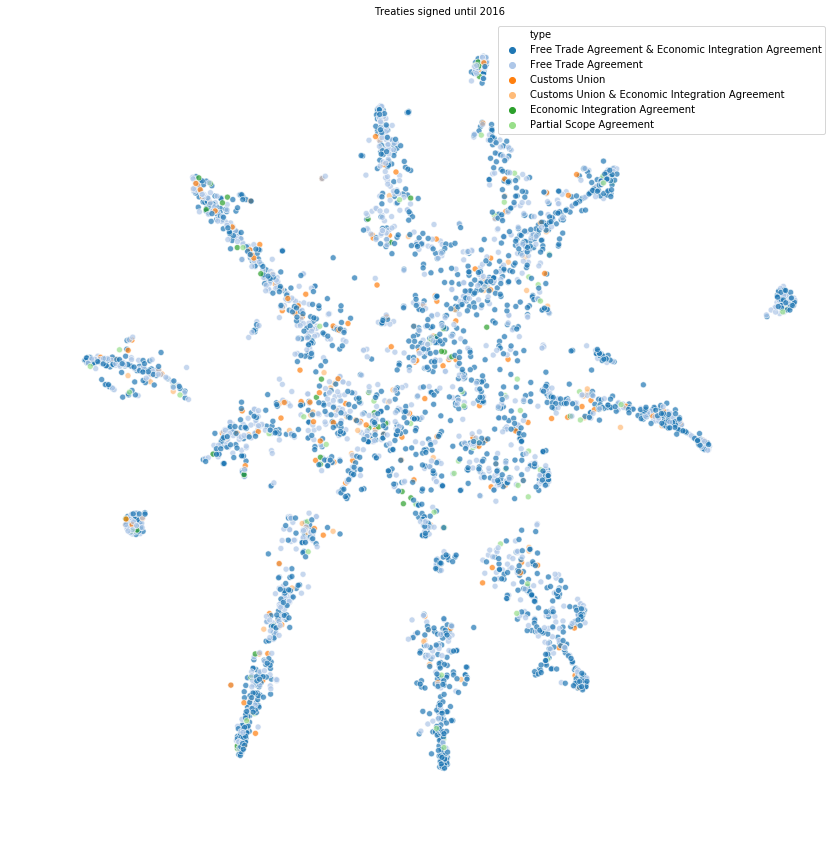

In [337]:
# color_list = plt.cm.tab20(np.linspace(0, 1, len(textdf.type.unique())))


# color = [r,g,b, a]
legend_list = []

# for i in range(len(topics)):   
#     color = color_list[i]
#     legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))


fig, axs = plt.subplots(figsize=(14, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)
data=tsne_embedding

scatter = sns.scatterplot(data=data, x='x',y='y', hue='type', palette='tab20',alpha=0.7)
axs.set_title('Treaties signed until {}'.format(year),**{'fontsize':'10'})
axs.axis('off')

#     fig.legend(legend_list, topics, loc=(0.2,0.89), ncol=5)
plt.subplots_adjust(top=0.85)

In [131]:
# tsne_embedding.head()

,x,y,hue
0,21.444233,-21.516930,0
1,25.884550,21.890593,1
2,1.572997,-44.780231,0
3,0.185350,42.520416,0
4,8.154202,4.185980,1


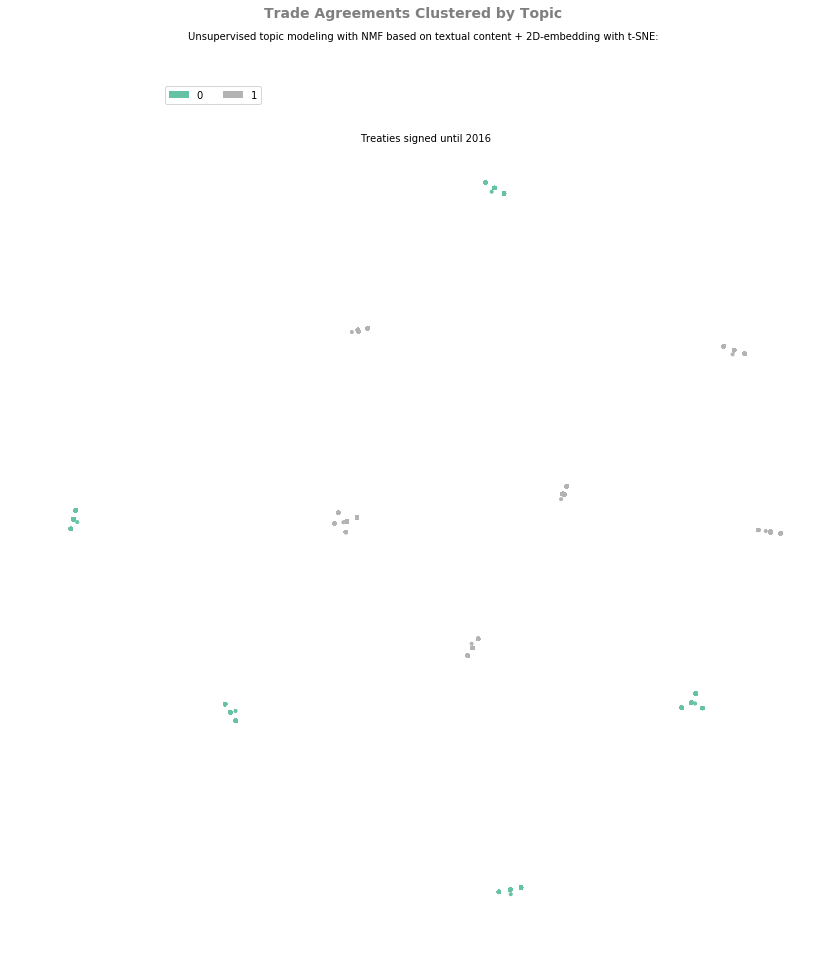